# liar

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import re
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling, BertForMaskedLM
import openpyxl
from torch import tensor
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances

## Sanity Test

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/shiyi/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'ran

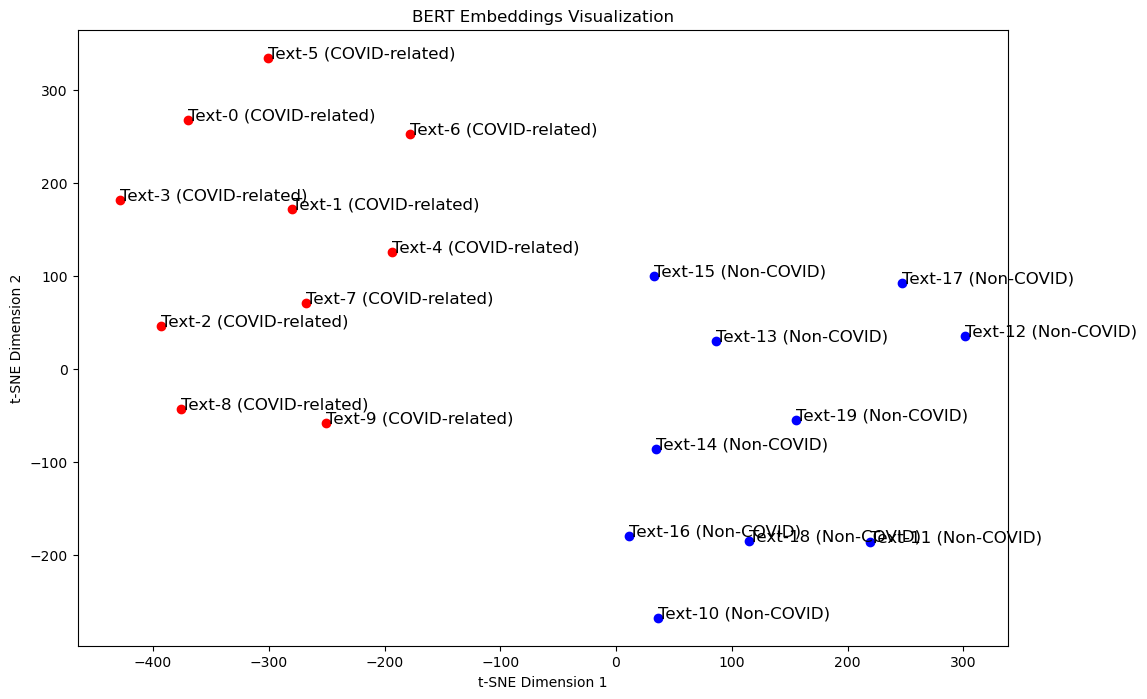

In [17]:
# 初始化 BERT 模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# 定义获取 BERT 嵌入的函数
def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy())
    return np.array(embeddings)

# 定义一小批示例文本和标签
texts = [
    # COVID-related sentences
    "The COVID-19 vaccine rollout is happening.",
    "COVID cases are spiking in my area.",
    "Due to the pandemic, the event was cancelled.",
    "What are the symptoms of the coronavirus?",
    "People are stockpiling hand sanitizers due to COVID.",
    "COVID-19 has impacted the global economy.",
    "Social distancing is key to stop the spread.",
    "Schools have been closed due to COVID-19.",
    "Many people have lost their jobs due to the pandemic.",
    "Healthcare workers are on the frontline.",

    # Non-COVID-related sentences
    "I like to play video games.",
    "She is going on a vacation to the mountains.",
    "I bought a new pair of shoes.",
    "The book I read was fantastic.",
    "I love Italian food.",
    "The movie was not that great.",
    "I like to listen to classical music.",
    "I bought a new phone.",
    "I love to travel and see new places.",
    "My dog is really cute.",
]

# Labels for these texts
labels = [1]*10 + [0]*10  # First 10 are COVID-related (1), next 10 are not (0)

# 获取 BERT 嵌入
embeddings = get_bert_embeddings(texts)

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, perplexity=10, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# 进行可视化
plt.figure(figsize=(12, 8))

for i, label in enumerate(labels):
    x, y = embeddings_2d[i]
    if label == 1:
        plt.scatter(x, y, c='r')
        plt.text(x, y, f"Text-{i} (COVID-related)", fontsize=12)
    else:
        plt.scatter(x, y, c='b')
        plt.text(x, y, f"Text-{i} (Non-COVID)", fontsize=12)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('BERT Embeddings Visualization')
plt.show()

## ------------

In [18]:
train = pd.read_csv('train.csv',delimiter='\t')
test = pd.read_csv('test.csv',delimiter='\t')
valid = pd.read_csv('valid.csv',delimiter='\t')
train.head()

,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0.1,0.2,0.3,a mailer
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [19]:
replace_dict = {'half-true': 0, 'mostly-true': 0, 'false': 0, 'true': 1, 'barely-true': 0, 'pants-fire': 0}

train['false'] = train['false'].replace(replace_dict)

test['true'] = test['true'].replace(replace_dict)

valid['barely-true'] = valid['barely-true'].replace(replace_dict)

value_counts = train['false'].value_counts()


print(value_counts)

0    8563
1    1676
Name: false, dtype: int64


In [20]:
label_train = train['false'].tolist()
label_test = test['true'].tolist()
train_set = train['Says the Annies List political group supports third-trimester abortions on demand.'].tolist()
test_set = test['Building a wall on the U.S.-Mexico border will take literally years.'].tolist()
unlabeled = valid['We have less Americans working now than in the 70s.'].tolist()

In [25]:
# 这个函数现在接受一个额外的参数：model
def get_bert_embeddings(news_articles, model):
    embeddings = []
    for article in news_articles:
        inputs = tokenizer(article, return_tensors="pt", max_length=512, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state[0][0].numpy())
    return np.array(embeddings)

## Neural network

In [26]:
#官方分的数据集

from transformers import BertModel, BertTokenizer

model = BertModel.from_pretrained('bert-base-uncased')

class FakeNewsClassifier(nn.Module):
    def __init__(self, input_dim):
        super(FakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)  # Batch Normalization
        self.dropout1 = nn.Dropout(0.5)  # Dropout

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.relu(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))
        return x

train_embeddings = get_bert_embeddings(train_set, model)
test_embeddings = get_bert_embeddings(test_set, model)

X_train = torch.tensor(train_embeddings, dtype=torch.float32)
y_train = torch.tensor(label_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(test_embeddings, dtype=torch.float32)
y_test = torch.tensor(label_test, dtype=torch.float32).unsqueeze(1)

model = FakeNewsClassifier(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

model.eval()
with torch.no_grad():
    predictions = model(X_test)

predicted_labels = (predictions > 0.5).float()
correct = (predicted_labels == y_test).sum().item()
total = y_test.size(0)
accuracy = correct / total

print(f"Neural Network Accuracy on Test Data: {accuracy * 100:.2f}%")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 0, Loss: 0.7492954134941101
Epoch 10, Loss: 0.5692583322525024
Epoch 20, Loss: 0.47346946597099304
Epoch 30, Loss: 0.42063015699386597
Epoch 40, Loss: 0.3806533217430115
Epoch 50, Loss: 0.33613789081573486
Epoch 60, Loss: 0.29273343086242676
Epoch 70, Loss: 0.24476811289787292
Epoch 80, Loss: 0.20113250613212585
Epoch 90, Loss: 0.17075827717781067
Neural Network Accuracy on Test Data: 74.41%


## 官方分的数据集来跑 svm

In [68]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_embeddings, label_train)

predicted_labels = svm_classifier.predict(test_embeddings)

accuracy = accuracy_score(label_test, predicted_labels) * 100
print(f"SVM Accuracy: {accuracy:.2f}%")

SVM Accuracy: 61.22%


## 官方分的数据集

In [ ]:
#前面的神经网络跑过就不跑了
train_embeddings = get_bert_embeddings(train_set, fine_tuned_model)
test_embeddings = get_bert_embeddings(test_set, fine_tuned_model)

X_train = torch.tensor(train_embeddings, dtype=torch.float32)
y_train = torch.tensor(label_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(test_embeddings, dtype=torch.float32)
y_test = torch.tensor(label_test, dtype=torch.float32).unsqueeze(1)

#label_train--remaining_labels
#label_test--sample_labels

In [29]:
distance_matrix = euclidean_distances(train_embeddings,test_embeddings)
print(np.amin(distance_matrix, axis=1))
nearest_indices = np.argmin(distance_matrix, axis=1)
predicted_labels = np.array([label_test[i] for i in nearest_indices])

accuracy = accuracy_score(label_train, predicted_labels)

min_values = np.amin(distance_matrix, axis=1)

# 计算平均值
mean_value = np.mean(min_values)
print(f"Average of minimum values: {mean_value}")

# 计算中位数
median_value = np.median(min_values)
print(f"Median of minimum values: {median_value}")
print(f"Nearest-neighbor Accuracy: {accuracy:.2f}%")

[7.5555606 6.8756776 6.764519  ... 6.4473777 5.873311  7.1212015]
Average of minimum values: 6.857911586761475
Median of minimum values: 6.809322834014893
Nearest-neighbor Accuracy: 0.72%


In [30]:
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(test_embeddings)

cluster_to_label = {}
for i in range(n_clusters):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    cluster_labels = np.array(label_test)[cluster_indices]
    majority_label = np.argmax(np.bincount(cluster_labels))
    cluster_to_label[i] = majority_label

predicted_cluster_labels = kmeans.predict(train_embeddings)
predicted_labels = np.array([cluster_to_label[label] for label in predicted_cluster_labels])

accuracy = accuracy_score(label_train, predicted_labels)

min_values = np.amin(distance_matrix, axis=1)

# 计算平均值
mean_value = np.mean(min_values)
print(f"Average of minimum values: {mean_value}")

# 计算中位数
median_value = np.median(min_values)
print(f"Median of minimum values: {median_value}")
print(f"K-means Clustering Accuracy: {accuracy:.2f}%")

Average of minimum values: 6.857911586761475
Median of minimum values: 6.809322834014893
K-means Clustering Accuracy: 0.83%


# 用train来fit


In [33]:
distance_matrix = euclidean_distances(test_embeddings,train_embeddings,)
print(np.amin(distance_matrix, axis=1))
nearest_indices = np.argmin(distance_matrix, axis=1)
predicted_labels = np.array([label_train[i] for i in nearest_indices])

accuracy = accuracy_score(label_test, predicted_labels)

min_values = np.amin(distance_matrix, axis=1)

# 计算平均值
mean_value = np.mean(min_values)
print(f"Average of minimum values: {mean_value}")

# 计算中位数
median_value = np.median(min_values)
print(f"Median of minimum values: {median_value}")
print(f"Nearest-neighbor Accuracy: {accuracy:.2f}%")

[5.686384  5.4290214 6.0796437 ... 8.803511  6.3838687 5.5166607]
Average of minimum values: 6.2571306228637695
Median of minimum values: 6.279517650604248
Nearest-neighbor Accuracy: 0.74%


In [36]:
n_clusters = 150
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(train_embeddings)

cluster_to_label = {}
for i in range(n_clusters):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    cluster_labels = np.array(label_train)[cluster_indices]
    majority_label = np.argmax(np.bincount(cluster_labels))
    cluster_to_label[i] = majority_label

predicted_cluster_labels = kmeans.predict(test_embeddings)
predicted_labels = np.array([cluster_to_label[label] for label in predicted_cluster_labels])

accuracy = accuracy_score(label_test, predicted_labels)

min_values = np.amin(distance_matrix, axis=1)

# 计算平均值
mean_value = np.mean(min_values)
print(f"Average of minimum values: {mean_value}")

# 计算中位数
median_value = np.median(min_values)
print(f"Median of minimum values: {median_value}")
print(f"K-means Clustering Accuracy: {accuracy:.2f}%")

Average of minimum values: 6.2571306228637695
Median of minimum values: 6.279517650604248
K-means Clustering Accuracy: 0.84%
